# Praktikum 2020 - Plots
This notebook sample plots from the following data sources in `{basedir}/postprocessed/` that have been prepared using the notebook `praktikum_preprocess.ipynb`
- Operational System (Friedrichs)
- Praktikum System
- Lighthouse data
- Sonic output
- Licor output

In [1]:
# import packages we need in this notebook
%matplotlib inline
import pandas as pd
import dask.dataframe as dd
from datetime import datetime, timedelta, date
import time, os
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

pd.set_option('display.max_columns', None)

In [9]:
def linreg(x,y):
    # x and y might have different numbers of missing values
    # so we must make x, y have missing values in the same places
    mask = x.isna() | y.isna()
    x_new = x.mask(mask).dropna()
    y_new = y.mask(mask).dropna()
    slope, intercept, r_value, p_value, std_err = linregress( x_new, y_new )
    
    # predict values
    # We take the min and max values of temperature_hygro, put these two values in an array, then multiply by slope and add intercept
    x_sort = np.sort(x_new)
    y_pred = x_sort * slope + intercept 
    return slope, intercept, r_value, p_value, std_err, x_sort, y_pred


In [10]:
basedir="/Users/jkjellsson/Downloads/praktikum_summer_2020/"

licor_file_output=f'{basedir}/postprocessed/licor_8min.csv'
sonic_file_output=f'{basedir}/postprocessed/sonic.csv'
friedrichs_operational_output=f'{basedir}/postprocessed/friedrichs_operational_8min.csv'
friedrichs_praktikum_output=f'{basedir}/postprocessed/friedrichs_praktikum_8min.csv'
lighthouse_operational_output=f'{basedir}/postprocessed/lighthouse_operational_8min.csv'

handheld_data=f'{basedir}/praktikum_sheet.csv'

## Plot handheld measurements

In [11]:
data = (pd.read_csv(handheld_data)).set_index('Date').replace(-999,np.NaN)
# Set new column names to make them easier to retrieve in the code
column_names = ['pressure_baro', 'temperature_baro', 'temperature_hygro', 'relhum', 'abshum', 'dry_temp', 'wet_temp', 'cloud_cover', 'pressure_tend', 'visibility', 'conditions']
data.columns = column_names

Text(0.8, 0.1, 'k = 1.070, r2 = 0.921')

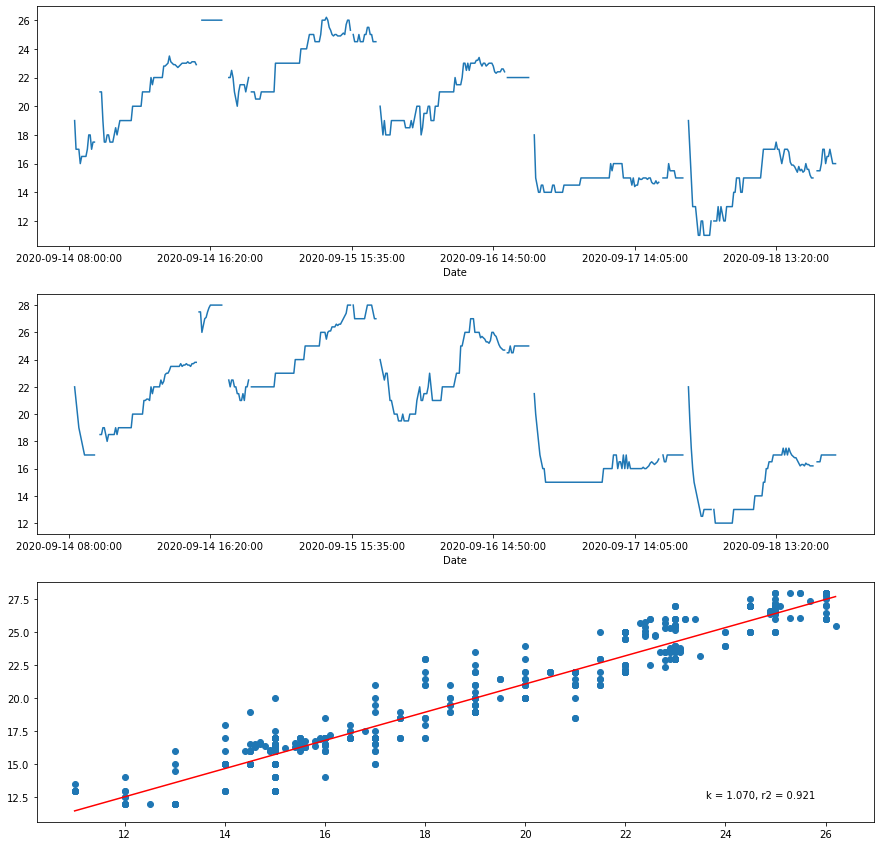

In [12]:
# Plot hygrometer temp and barometer temp
# plt.subplots will create 3 rows x 1 columns with subplots
# ax is a list of all subplots
# the figsize argument is the width,height of the plot. 
fig, ax = plt.subplots(3,1, figsize=(15,15))

# Plot time series of hygro temp
# We assign this plot to ax[0], which is the first element in ax. Python indices start at 0
data['temperature_hygro'].plot(ax=ax[0])

# Plot timeseries of barom temp
# Assign this to ax[1], the second element in ax
data['temperature_baro'].plot(ax=ax[1])

# Plot them against each other
# For this we use a scatter plot. Each data point is a circle
ax[2].scatter( data['temperature_hygro'], data['temperature_baro'], marker='o' )

# Now lets do a linear regression 
# I wrote a function for this since we need to deal with missing values
slope, intercept, r_value, p_value, std_err, xp, yp = linreg(data['temperature_hygro'], data['temperature_baro'])

# Calculate fitted line
# i.e. we use the hygrometer temperature to predict barometer temperatures
ax[2].plot(xp, yp, '-r')

# Print stats to plot
ax[2].text(0.8,0.1,'k = %5.3f, r2 = %5.3f' % (slope, r_value**2), transform=ax[2].transAxes)

# Pretty good linear regression, so the two timeseries agree

2020-09-14 07:00:00          NaN
2020-09-14 08:00:00          NaN
2020-09-14 09:00:00    15.300000
2020-09-14 10:00:00    17.488889
2020-09-14 11:00:00    18.883333
                         ...    
2020-09-19 09:00:00          NaN
2020-09-19 10:00:00          NaN
2020-09-19 11:00:00          NaN
2020-09-19 12:00:00          NaN
2020-09-19 13:00:00          NaN
Freq: 60T, Name: dry_temp, Length: 127, dtype: float64


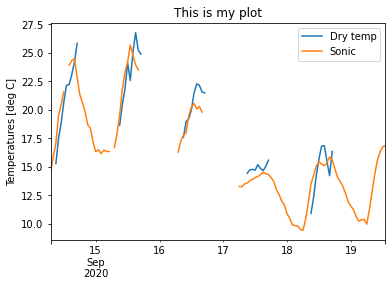

In [23]:
# Plot sonic temperature against hand held measurements

# Read sonic
data_sonic = (pd.read_csv(sonic_file_output)).set_index('timestamp')

temp_sonic = data_sonic['T']

# The measurements are taken at different time intervals, so we need to resample the data sets
# Here I opt for hourly data
temp_sonic.index = pd.to_datetime(temp_sonic.index)
temp_sonic_1h = temp_sonic.dropna().resample('60min',closed='right',label='right').mean()

temp_dry = data['dry_temp']
temp_dry.index = pd.to_datetime(temp_dry.index)
temp_dry_1h = temp_dry.dropna().resample('60min',closed='right',label='right').mean()

# Align the two time series. 
# Make temp_dry be as long as temp_sonic
temp_dry_1h_align, temp_sonic_1h_align = temp_dry_1h.align(temp_sonic_1h)
print(temp_dry_1h_align)

# Plot 
fig, ax = plt.subplots(1,1)
temp_dry_1h_align.plot(ax=ax,label='Dry temp')
temp_sonic_1h_align.plot(ax=ax,label='Sonic')

# Set yaxis label
ax.set_ylabel('Temperatures [deg C]') 
# Set title
ax.set_title('This is my plot')
# Insert legend
# The legend will take the names from the labels in the plot commands
ax.legend()